In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import mean, count, avg, col, row_number, udf
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression as SKLinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor as SKDecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor, GradientBoostingRegressor

from figure_labeler import *

from IPython.display import HTML
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
fl = FigureLabeler();
pd.options.mode.chained_assignment = None

<h1 style="text-align:center;">Unlocking Salary Trends: Predictive Insights for Software Professionals</h1>
<hr>

<a name="top"></a>
#### Table of Contents:

[ref0]: #exec_summary
- [Executive Summary][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref2]: #motiv
- [Motivation][ref2]

[ref3]: #dat_sor
- [Data Source][ref3]

[ref4]: #dat_prep
- [Data Preprocessing][ref4]

[ref5]: #dat_expl
- [Data Exploration][ref5]

[ref6]: #res_dis
- [Results and Discussions][ref6]

[ref7]: #conc
- [Conclusion and Recommendations][ref7]

[ref8]: #refe
- [References][ref8]

***

<a name="exec_summary"></a>
## Executive Summary
In this section, we provide an overview of our analysis of software professional salaries.
***

Understanding salary trends is crucial in today's competitive job market. Our analysis focuses on software professional salaries, including data on company names, job titles, locations, and employment statuses. The goal is to uncover key patterns and trends to help professionals and companies make informed decisions.

We preprocess the data by filling missing numerical values with column means and standardizing column names. We then explore the data to identify significant trends, such as the distribution of jobs across different locations, the prevalence of various job titles, and the average salaries associated with these roles. Our analysis includes visualizations to illustrate the number of jobs, the average salaries, and the top-paying companies in different locations. By highlighting these trends, we aim to provide valuable insights into the job market for software professionals.

To further enhance our understanding, we apply machine learning models like Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosted Trees (GBT) Regressor to predict salaries based on various factors. Evaluation metrics such as RMSE and R-squared are used to assess the performance of these models. These insights and predictions can guide professionals in negotiating salaries and choosing career paths, while helping companies design competitive compensation packages and make strategic hiring decisions.

[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
## Problem Statement
In this section, we define the problem of predicting software professional salaries based on various factors.
***

The primary objective of this project is to develop predictive models to estimate salaries based on factors such as company names, job titles, locations, and employment statuses. To accomplish this, we preprocess the data and apply several regression models—Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosted Trees Regressor. The performance of these models will be evaluated using metrics like RMSE and R-squared, allowing for a comparison of their predictive accuracy and effectiveness. By interpreting the results and visualizations from these models, the analysis aims to provide actionable insights that can guide professionals and companies in making informed salary decisions.

[ref]: #top
[Back to Table of Contents][ref]

<a name="motiv"></a>
## Motivation
In this section, we explain the importance of understanding salary trends and how predictive modeling can enhance decision-making for professionals and companies.
***

By looking at salary data, professionals can make better decisions about their careers and salary talks. Companies can use this information to create competitive pay packages and make smart hiring choices. This analysis aims to use machine learning to find trends and insights that help everyone make better decisions in the software job market.

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_sor"></a>
## Data Source
In this section, the data source of the study is indicated.
***

The analysis is based on a dataset titled "22700+ Software Professional Salary Dataset" by A. Chauhan (2023, July 9) from Kaggle. This dataset includes detailed information on software professional salaries, such as company names, job titles, locations, and employment statuses. It is gathered from various industry sources to provide a thorough view of the job market.

*Click this for the dataset:* [Dataset Link](https://www.kaggle.com/datasets/whenamancodes/software-professional-salary-dataset/code)

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_prep"></a>
## Data Preprocessing
***

In this section, we load the datasets, replace spaces in column names with underscores, and fill missing numerical values with the mean of the respective columns.

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .appName('AdCampaignEarningsPrediction')
        .getOrCreate()
)

In [4]:
salary = spark.read.csv('Salary_Dataset_with_Extra_Features.csv', 
                            header=True, 
                            inferSchema=True)
software = spark.read.csv('Software_Professional_Salaries.csv', 
                         header=True, 
                         inferSchema=True)

In [5]:
fl.table_caption('The Salary DataFrame',
                 'The dataframe of salary dataset with extra features.')
salary.show(5)

+------+--------------------+-----------------+-------+-----------------+---------+-----------------+---------+
|Rating|        Company Name|        Job Title| Salary|Salaries Reported| Location|Employment Status|Job Roles|
+------+--------------------+-----------------+-------+-----------------+---------+-----------------+---------+
|   3.8|              Sasken|Android Developer| 400000|                3|Bangalore|        Full Time|  Android|
|   4.5|Advanced Millenni...|Android Developer| 400000|                3|Bangalore|        Full Time|  Android|
|   4.0|           Unacademy|Android Developer|1000000|                3|Bangalore|        Full Time|  Android|
|   3.8|  SnapBizz Cloudtech|Android Developer| 300000|                3|Bangalore|        Full Time|  Android|
|   4.4|Appoids Tech Solu...|Android Developer| 600000|                3|Bangalore|        Full Time|  Android|
+------+--------------------+-----------------+-------+-----------------+---------+-----------------+---

In [6]:
fl.table_caption('The Software Professional Salaries DataFrame',
                 'The dataframe of software professional salaries.')
software.show(5)

+------+--------------------+-----------------+-------+-----------------+---------+
|Rating|        Company Name|        Job Title| Salary|Salaries Reported| Location|
+------+--------------------+-----------------+-------+-----------------+---------+
|   3.8|              Sasken|Android Developer| 400000|                3|Bangalore|
|   4.5|Advanced Millenni...|Android Developer| 400000|                3|Bangalore|
|   4.0|           Unacademy|Android Developer|1000000|                3|Bangalore|
|   3.8|  SnapBizz Cloudtech|Android Developer| 300000|                3|Bangalore|
|   4.4|Appoids Tech Solu...|Android Developer| 600000|                3|Bangalore|
+------+--------------------+-----------------+-------+-----------------+---------+
only showing top 5 rows



In [7]:
salary.printSchema()
software.printSchema()

root
 |-- Rating: double (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Salaries Reported: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Employment Status: string (nullable = true)
 |-- Job Roles: string (nullable = true)

root
 |-- Rating: double (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Salaries Reported: integer (nullable = true)
 |-- Location: string (nullable = true)



In [8]:
salary = salary.toDF(*(c.replace(' ', '_') for c in salary.columns))
software = software.toDF(*(c.replace(' ', '_') for c in software.columns))

In [9]:
for col_name in salary.columns:
    if dict(salary.dtypes)[col_name] in ['int', 'double']:
        mean_value = salary.select(mean(col(col_name))).collect()[0][0]
        salary = salary.na.fill({col_name: mean_value})

In [10]:
for col_name in software.columns:
    if dict(software.dtypes)[col_name] in ['int', 'double']:
        mean_value = software.select(mean(col(col_name))).collect()[0][0]
        software = software.na.fill({col_name: mean_value})

In [11]:
salary.printSchema()
software.printSchema()

root
 |-- Rating: double (nullable = false)
 |-- Company_Name: string (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Salaries_Reported: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Employment_Status: string (nullable = true)
 |-- Job_Roles: string (nullable = true)

root
 |-- Rating: double (nullable = false)
 |-- Company_Name: string (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Salaries_Reported: integer (nullable = true)
 |-- Location: string (nullable = true)



In [12]:
unique_companies = salary.select("Company_Name").distinct().count()
print(f'Number of unique companies in the salary dataset: {unique_companies}')

Number of unique companies in the salary dataset: 11261


<a name="dat_expl"></a>
## Data Exploration
***

In this section, we explore the dataset to find patterns in software professional salaries. We use group-by operations and bar plots to show the number of jobs in each location, compare average salaries across companies and job titles, and identify the most common job roles. These methods help us understand salary trends and provide useful insights for career and salary decisions.

In [13]:
fl.table_caption('Count of Employment Status per Location',
                 'The number of employment status in each location.')

employ_stat_count = (salary.groupBy('Employment_Status', 'Location')
                     .count()
                     .withColumnRenamed('count', 'Count')
                     .orderBy('Employment_Status', 'Location'))

employ_stat_count.show(10)

+-----------------+---------+-----+
|Employment_Status| Location|Count|
+-----------------+---------+-----+
|       Contractor|Bangalore|  248|
|       Contractor|  Chennai|   41|
|       Contractor|Hyderabad|  142|
|       Contractor|   Kerala|    1|
|       Contractor|  Kolkata|    1|
|       Contractor|   Mumbai|   15|
|       Contractor|New Delhi|   62|
|       Contractor|     Pune|   38|
|        Full Time|Bangalore| 7210|
|        Full Time|  Chennai| 2255|
+-----------------+---------+-----+
only showing top 10 rows



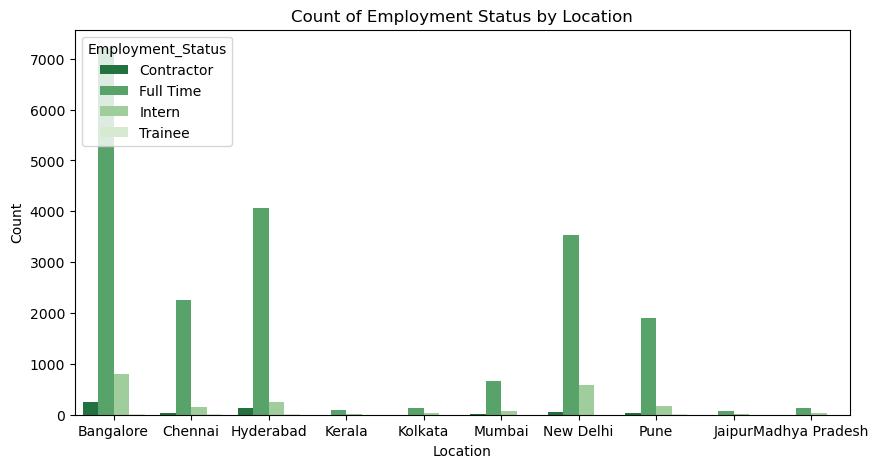

In [14]:
employ_stat_count_pd = employ_stat_count.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x='Location', y='Count', hue='Employment_Status', palette='Greens_r', data=employ_stat_count_pd)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Count of Employment Status by Location')
plt.show()

fl.fig_caption("Count of Employment Status by Location",
               "The bar graph illustrates the quantity of employment status in each location.")

The x-axis shows the location while the y-axis shows the number count. The legend represents the employment status level which has, contractor, full time, intern, and trainee. Observing the bar graph, among all the locations full time has the highest count implying that most locations have the highest number of full time employees. The location, Bangalore, has the highest count of full time employment status among the locations with over seven thousand count. The least shown employment status is the intern across all the locations.

In [15]:
location_counts = (salary.groupBy('Location')
                   .agg(count('Company_Name').alias('Company_Count'))
                   .orderBy('Company_Count', ascending=False))

lcpd = location_counts.toPandas()

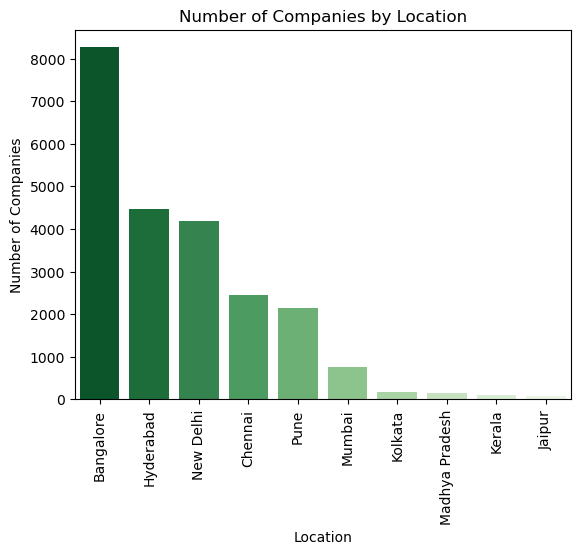

In [16]:
sns.barplot(x=lcpd['Location'], y=lcpd['Company_Count'], palette='Greens_r')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of Companies')
plt.title('Number of Companies by Location')
plt.show()

fl.fig_caption("Number of Companies by Location",
               "The bar graph illustrates the number of companies in each location.")

The x-axis shows the location and the y-axis shows the numerical count of companies. It is highly evident that the highest location by number of companies is in Bangalore, which can correspond to the previous bar graph that the highest employment status of full time workers are also in Bangalore. Following Bangalore, is Hyderabad and New Delhi, while the least number of companies in that location is Jaipur. 

In [17]:
fl.table_caption('Computed Average Salary per Company Name',
                 'The measured average salary in each company.')

salary_comp = (salary.groupBy('Company_Name')
               .agg(avg('Salary').alias('Average_Salary'))
               .orderBy('Average_Salary', ascending=False))

salary_comp.show(10)

+--------------------+--------------+
|        Company_Name|Average_Salary|
+--------------------+--------------+
|   Thapar University|         9.0E7|
|        Digital Raju|     9800000.0|
|     FFF Enterprises|     9800000.0|
|Gaana Lyrics Poin...|     9700000.0|
|GGH Heavy Industries|     9600000.0|
|             Tenneco|     7700000.0|
|Adwitech Info Sys...|     7300000.0|
|   Techware Solution|     6900000.0|
|              KH TEC|     6600000.0|
|     Nikhil Comforts|     6400000.0|
+--------------------+--------------+
only showing top 10 rows



In [18]:
salary_mean = (salary.groupBy('Location')
               .agg(avg('Salary').alias('Average_Salary'))
               .orderBy('Average_Salary', ascending=False))

salary_mean_pd = salary_mean.toPandas()

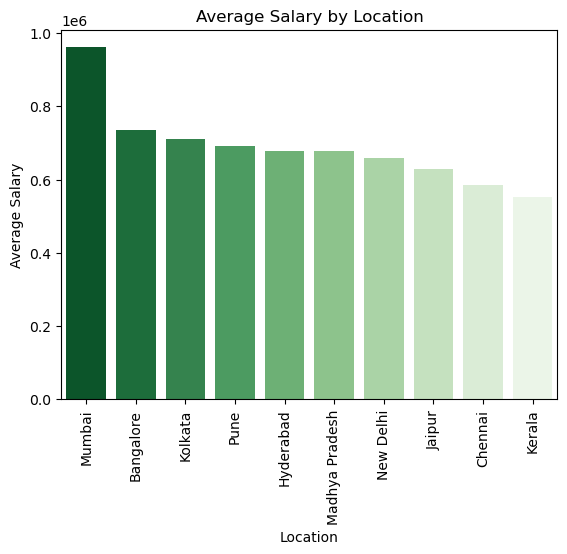

In [19]:
sns.barplot(x='Location', y='Average_Salary', data=salary_mean_pd, palette='Greens_r')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Average Salary')
plt.title('Average Salary by Location')
plt.show()

fl.fig_caption("Average Salary by Location",
               "The bar graph illustrates the computed average salary of an employee in each location.")

The x-axis shows the location and the y-axis shows the numerical average salary. After computing the measured salary of the given company by location, the highest earned average salary is in the location of Mumbai that follows Bangalore and Kolkata. While the least average salary among the locations is Kerala. This implies that in the location of Mumbai, their gained average salary is higher than the other locations. 

In [20]:
max_salary_location = (salary.groupBy('Location')
                       .agg(avg('Salary').alias('Max_Salary')))

window_spec = Window.partitionBy('Location').orderBy(col('Salary').desc())
highest_salary_companies = (salary.withColumn('Rank', row_number().over(window_spec))
                            .filter(col('Rank') <= 5)
                            .orderBy(col('Salary').desc()))

highest_salary_companies_pd = highest_salary_companies.toPandas()

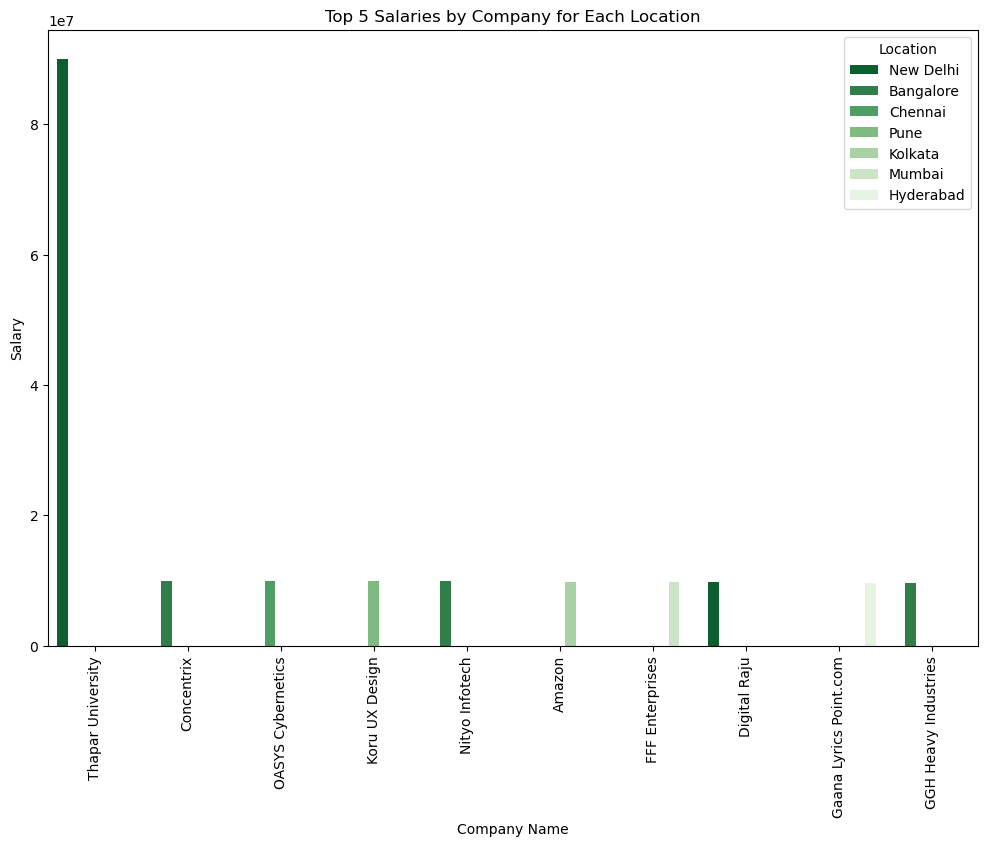

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Company_Name', y='Salary', hue='Location', data=highest_salary_companies_pd.head(10), palette='Greens_r')
plt.xticks(rotation=90)
plt.xlabel('Company Name')
plt.ylabel('Salary')
plt.title('Top 5 Salaries by Company for Each Location')
plt.show()

fl.fig_caption("Top 5 Salaries by Company for Each Location",
               "The bar graph illustrates the top 5 highest salaries within its company regulation in each location.")

The x-axis shows the company name while the y-axis shows the salary count. The legend represents the location. As seen in the graph, the highest company that contains a major salary is Thapar University in New Delhi. While the rest of the companies in certain locations have a below average salary. This can be observed that Thapar University shows significantly above average salary among other companies. 

In [22]:
average_salary_by_job = (salary.groupBy('Job_Title')
                         .agg(avg('Salary').alias('Average_Salary'))
                         .orderBy('Average_Salary', ascending=False))

average_salary_by_job_pd = average_salary_by_job.toPandas()

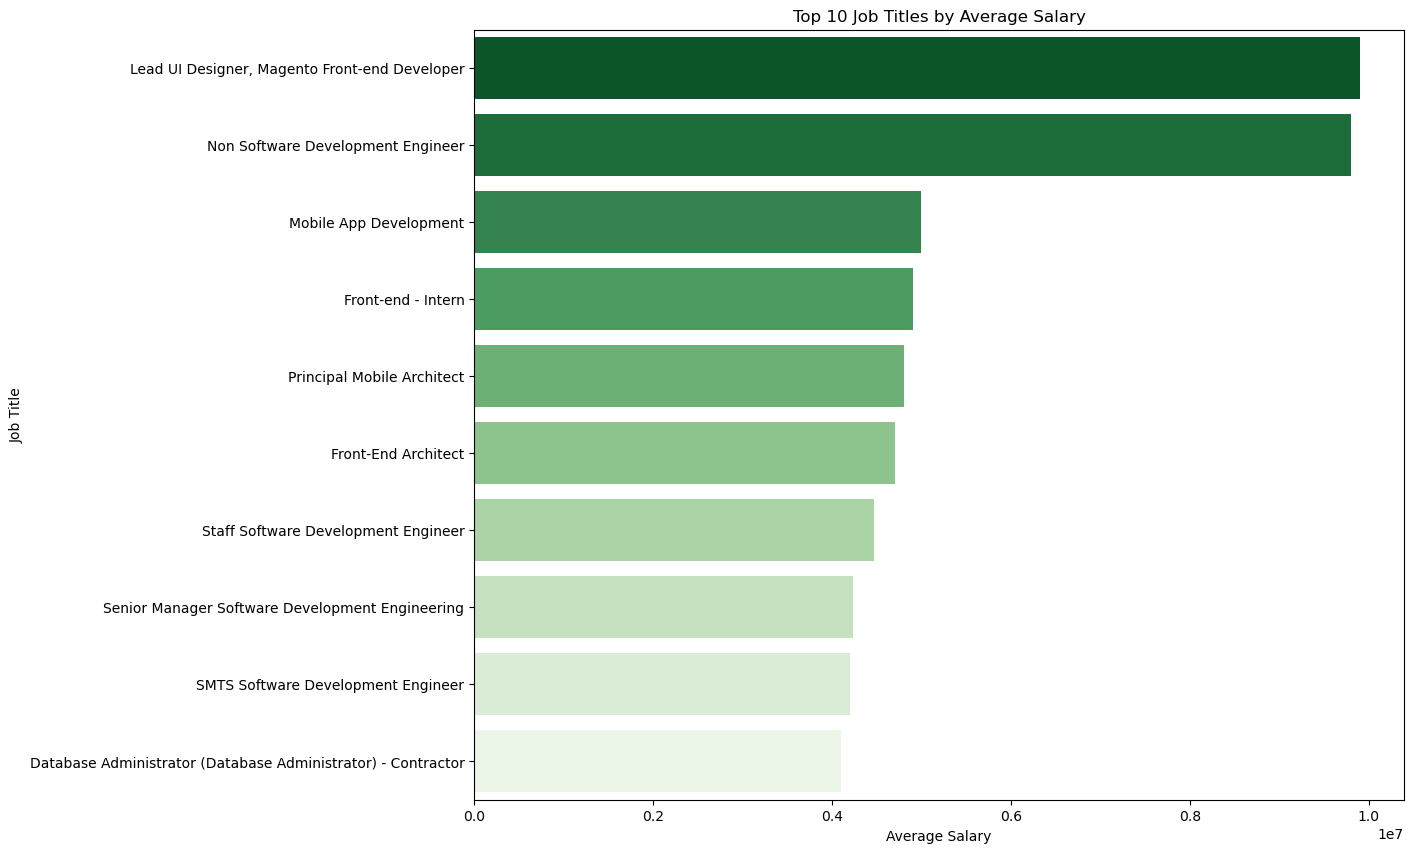

In [23]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Average_Salary', y='Job_Title', data=average_salary_by_job_pd.head(10), palette='Greens_r')
plt.xlabel('Average Salary')
plt.ylabel('Job Title')
plt.title('Top 10 Job Titles by Average Salary')
plt.show()

fl.fig_caption("Top 10 Job Titles by Average Salary",
               "The bar graph illustrates the top 10 highest job titles accoring to its average salary in each location.")

The x-axis shows the job title and the y-axis shows the computed average salary. As seen in the graph, the job title that has the highest average salary is the Lead UI Designer, Magento Front-end Developer, and next to it is the Non Software Development Engineer.This implies that the employees having the mentioned job title gained the highest average salary among other job titles. 

In [24]:
job_roles_count = (salary.groupBy('Job_Roles')
                   .agg(count('Job_Roles').alias('Count'))
                   .orderBy('Count', ascending=False))

job_roles_count_pd = job_roles_count.toPandas()

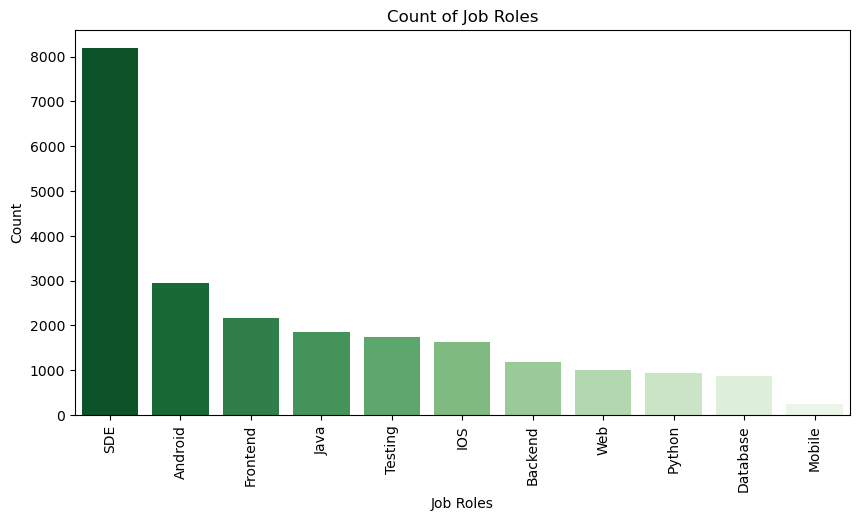

In [25]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Job_Roles', y='Count', data=job_roles_count_pd, order=job_roles_count_pd['Job_Roles'], palette='Greens_r')
plt.xticks(rotation=90)
plt.xlabel('Job Roles')
plt.ylabel('Count')
plt.title('Count of Job Roles')
plt.show()

fl.fig_caption("Count of Job Roles",
               "The bar graph illustrates the quantity of Job Roles.")

The x-axis represents the term of the job roles and the y-axis shows the numerical count. It is evident that the job role, SDE, has gained the highest count of job roles with over eight thousand. Meanwhile, the other job roles obtained around three thousand and lower in count. This means that the job role SDE has the most employee roles. 

In [26]:
print(f'Number of unique Job Titles: {salary.select("Job_Title").distinct().count()}')
print(f'Number of unique Job Roles: {salary.select("Job_Roles").distinct().count()}')

Number of unique Job Titles: 1080
Number of unique Job Roles: 11


In [27]:
job_titles_sample = salary.select('Job_Title').distinct().limit(50).toPandas()
print(job_titles_sample)

                                            Job_Title
0                             Front End Web Developer
1                           Mobile Developer - Intern
2                                    Mobile Architect
3      Senior Software Engineer - Product Development
4                             Senior Android Engineer
5          Senior Applications Database Administrator
6                      Senior Software Engineer (IOS)
7                          Senior Java/J2EE Developer
8             Software Engineer (Dot Net Development)
9             Trainee Engineer – Software Development
10                                             Tester
11                       Clinical Database Programmer
12                                 Front End Engineer
13                                IOS App Review WWDR
14            Software Development Associate Engineer
15           Junior Software Test Automation Engineer
16               QA Analyst, Automation Test Engineer
17             Senior Androi

In [28]:
def newCategory(x):
    if 'Intern' in x:
        return 0
    elif 'Junior' in x:
        return 1
    elif 'Developer' in x or 'Engineer' in x:
        return 2
    elif 'Lead' in x:
        return 3
    else:
        return 2

In [29]:
newCategory_udf = udf(newCategory, IntegerType())
salary = salary.withColumn('Job_title_n', newCategory_udf('Job_Title'))

In [30]:
indexers = [
    StringIndexer(inputCol='Location', outputCol='Location_Index'),
    StringIndexer(inputCol='Job_Roles', outputCol='Job_Roles_Index'),
    StringIndexer(inputCol='Employment_Status', outputCol='Employment_Status_Index')
]

In [31]:
encoders = [
    OneHotEncoder(inputCols=['Location_Index', 'Job_Roles_Index', 'Employment_Status_Index'],
                  outputCols=['Location_OHE', 'Job_Roles_OHE', 'Employment_Status_OHE'])
]

In [32]:
assembler = VectorAssembler(
    inputCols=['Job_title_n', 'Location_OHE', 'Job_Roles_OHE', 'Employment_Status_OHE'],
    outputCol='features'
)

In [33]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])

In [34]:
pipeline_model = pipeline.fit(salary)
df_transformed = pipeline_model.transform(salary)

In [35]:
X = df_transformed.select('features')
y = df_transformed.select('Salary')

In [36]:
train_data, test_data = df_transformed.randomSplit([0.75, 0.25], seed=42)

In [37]:
def get_cross_validator(model, param_grid):
    evaluator = RegressionEvaluator(labelCol='Salary', predictionCol='prediction', metricName='rmse')
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)
    return crossval

In [38]:
lr = LinearRegression(featuresCol='features', labelCol='Salary')
param_grid_lr = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build()
                )
cv_lr = get_cross_validator(lr, param_grid_lr)

In [39]:
dt = DecisionTreeRegressor(labelCol='Salary', featuresCol='features')
param_grid_dt = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15]).build()
cv_dt = get_cross_validator(dt, param_grid_dt)

In [40]:
rf = RandomForestRegressor(labelCol='Salary', featuresCol='features')
param_grid_rf = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [20, 50])
                 .addGrid(rf.maxDepth, [5, 10, 15])
                 .build()
                )
cv_rf = get_cross_validator(rf, param_grid_rf)

In [41]:
gbt = GBTRegressor(labelCol='Salary', featuresCol='features')
param_grid_gbt = (ParamGridBuilder()
                  .addGrid(gbt.maxDepth, [5, 10])
                  .addGrid(gbt.maxIter, [20, 50])
                  .build()
)
cv_gbt = get_cross_validator(gbt, param_grid_gbt)

In [42]:
models = {'LinearRegression': cv_lr, 
          'DecisionTreeRegressor': cv_dt, 
          'RandomForestRegressor': cv_rf, 
          'GBTRegressor': cv_gbt}
results = {}

for name, model in models.items():
    cv_model = model.fit(train_data)
    predictions = cv_model.transform(test_data)
    evaluator_rmse = RegressionEvaluator(labelCol='Salary', 
                                         predictionCol='prediction', 
                                         metricName='rmse')
    evaluator_r2 = RegressionEvaluator(labelCol='Salary', 
                                       predictionCol='prediction', 
                                       metricName='r2')
    evaluator_mae = RegressionEvaluator(labelCol='Salary', 
                                        predictionCol='prediction', 
                                        metricName='mae')
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae}

for name, metrics in results.items():
    print(f'{name} - '
          f'\033[1mRMSE:\033[0m {metrics["RMSE"]:.4f}, '
          f'\033[1mR2:\033[0m {metrics["R2"]:.4f}, '
          f'\033[1mMAE:\033[0m {metrics["MAE"]:.4f}')

LinearRegression - RMSE: 594365.4454, R2: 0.1154, MAE: 384144.1802
DecisionTreeRegressor - RMSE: 597245.8953, R2: 0.1068, MAE: 383039.2247
RandomForestRegressor - RMSE: 594732.7693, R2: 0.1143, MAE: 382844.1844
GBTRegressor - RMSE: 597381.8389, R2: 0.1064, MAE: 383046.0108


<Figure size 1200x600 with 0 Axes>

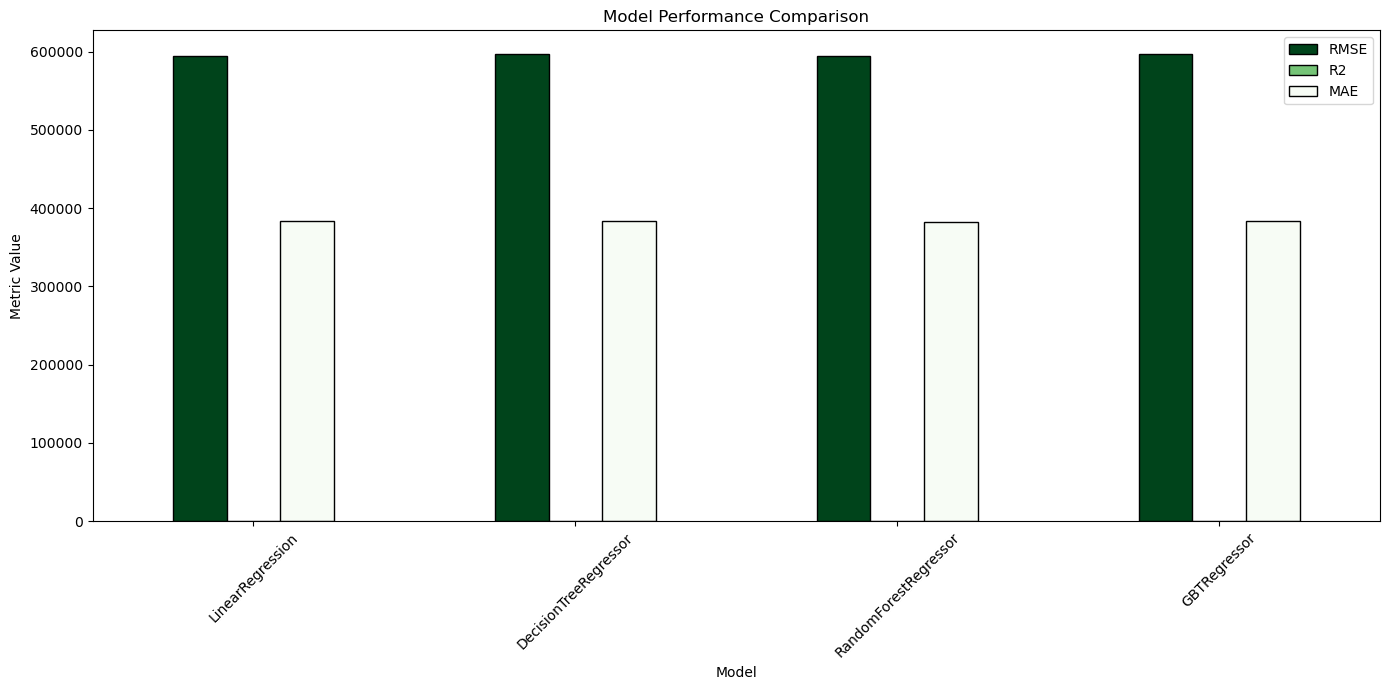

In [43]:
metrics_df = pd.DataFrame(results).T
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', 
                x='Model', 
                stacked=False, 
                colormap='Greens_r', 
                edgecolor='black', 
                figsize=(14, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

fl.fig_caption("Model Performance Comparison",
               "The bar graph compares the performance of different regression models based on RMSE, R2, and MAE metrics. Each bar represents a model's performance across these metrics.")

It evaluates four regression models: Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosted Trees Regressor. The RMSE values for all models are similar, around 600 thousand, indicating comparable prediction errors. The R-squared values are lower than RMSE, suggesting that none of the models are particularly effective at explaining the variance in the data. MAE values are also similar, around 400 thousand, showing that the models have similar average prediction errors. Overall, the graph shows that all four models perform similarly, with no single model significantly outperforming the others.

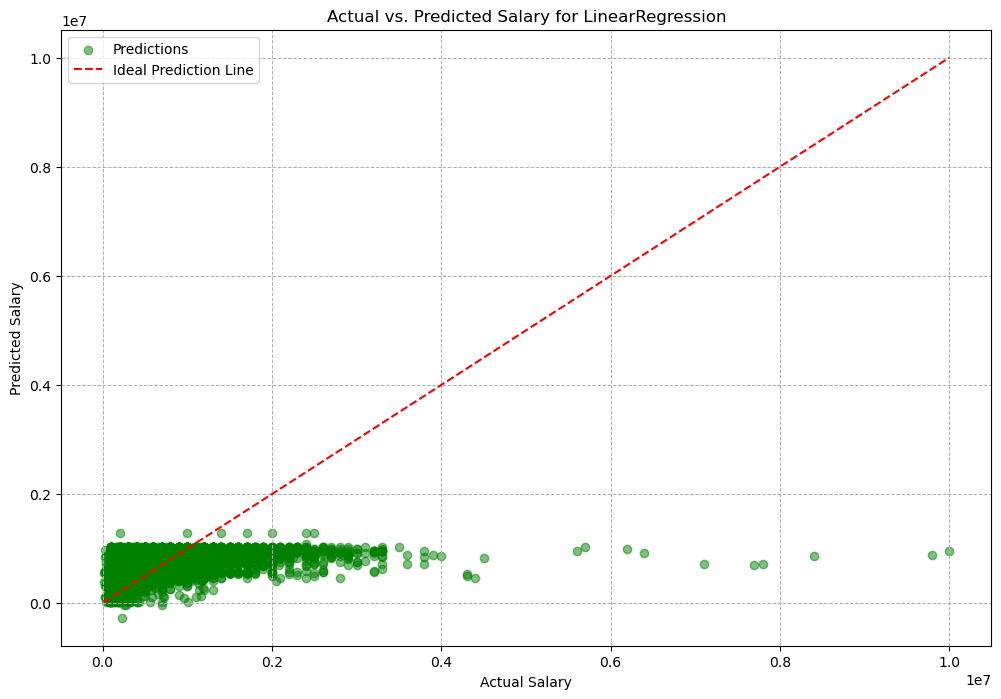

In [44]:
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = models[best_model_name].fit(train_data)
predictions = best_model.transform(test_data).toPandas()

plt.figure(figsize=(12, 8))
plt.scatter(predictions['Salary'], 
            predictions['prediction'], 
            alpha=0.5, 
            color='green', 
            label='Predictions')
plt.plot([predictions['Salary'].min(), 
          predictions['Salary'].max()],
         [predictions['Salary'].min(), 
          predictions['Salary'].max()], 
         color='red', linestyle='--', 
         label='Ideal Prediction Line')

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend(loc='best')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Actual vs. Predicted Salary for {best_model_name}')
plt.show()

fl.fig_caption("Actual vs. Predicted Salary for Best Model",
               "The scatter plot shows the comparison between actual and predicted salaries for the best-performing model. The red dashed line represents the ideal prediction where actual salaries match predicted values.")

This compares actual salaries (x-axis) with those predicted by the Linear Regression model (y-axis). The red dashed line represents perfect predictions, where all points would ideally lie. Green dots show that the model's predictions deviate significantly from this line, especially for higher salaries. Most predictions are clustered below the ideal line, indicating that the model consistently underestimates salaries, particularly at higher values. Overall, the plot reveals that the Linear Regression model performs poorly, especially for higher salary ranges, suggesting it may be underfitting the data.

[ref]: #top
[Back to Table of Contents][ref]

<a name="res_dis"></a>
## Results and Discussions
In this section, we present the outcomes of our salary prediction models and discuss their performance. 
***

**Count of Employment Status by Location**

The bar chart illustrates the distribution of employment status across various locations in India, with categories including Contractor, Full Time, Intern, and Trainee. Full-time employment is notably dominant across all locations, particularly in Bangalore, which has the highest count with approximately 6500 full-time employees. Hyderabad follows with around 4500 full-time employees, while other cities like Chennai, New Delhi, and Pune also show significant numbers in this category, with counts around 2000, 3000, and 2500 respectively. Mumbai has around 1000 full-time employees, whereas locations such as Kerala, Kolkata, Jaipur, and Madhya Pradesh have negligible counts across all employment statuses. The Contractor, Intern, and Trainee categories have significantly lower representation in all locations. Bangalore, in addition to its large full-time workforce, has around 500 contractors, but very few interns and trainees. Other cities show almost negligible numbers for contractors, interns, and trainees. Overall, the chart highlights a significant concentration of full-time employees in major metropolitan areas, with Bangalore leading by a large margin, while other employment statuses are sparsely represented across the regions.

**Number of Companies by Location**

The bar graph depicts the number of companies located in various cities across India. Bangalore emerges as the clear leader, hosting nearly 8000 companies, which is significantly higher than any other city. Hyderabad and New Delhi follow, each with around 4500 and 4000 companies respectively, indicating that these cities also serve as major business hubs. Chennai has approximately 3000 companies, while Pune has around 2500, showing a moderate presence of companies. Mumbai, with about 1000 companies, holds a smaller share compared to the top cities. Other locations such as Kolkata, Madhya Pradesh, Kerala, and Jaipur have a relatively minor presence in terms of company count, each hosting fewer than 1000 companies. The graph highlights Bangalore's dominant position as the primary location for companies, followed by a significant, though smaller, cluster of companies in Hyderabad and New Delhi. Other cities like Chennai and Pune also contribute to the business landscape, albeit to a lesser extent, while the remaining locations play a minimal role in the overall distribution of companies across India.

**Average Salary by Location**

The bar graph represents the average salary of employees across various locations in India. Mumbai stands out with the highest average salary, reaching nearly 1,000,000 units, making it the most lucrative city for employees in terms of salary. Following Mumbai, Bangalore and Kolkata show slightly lower average salaries, each around 800,000 units. Pune, Hyderabad, and Madhya Pradesh have comparable average salaries, each approximately 700,000 units, indicating a moderate earning potential in these regions. New Delhi and Jaipur follow closely, each with average salaries slightly above 600,000 units. Chennai and Kerala show the lowest average salaries, around 500,000 units, making them the least lucrative among the listed locations. This graph highlights Mumbai as the top city for high salaries, with Bangalore and Kolkata also offering competitive pay. Other cities like Pune, Hyderabad, and Madhya Pradesh provide moderate salary levels, while Chennai and Kerala present the lowest earning potential among the regions.

**Top 5 Salaries by Company for Each Location**

The bar graph illustrates the top five salaries by company in various locations across India, with salaries measured in millions. Thapar University in New Delhi stands out with a salary of 9 million, indicating an exceptionally high-paying position relative to the others. This suggests that Thapar University offers significantly higher compensation compared to other companies listed.

In contrast, Concentrix in Bangalore, OAYSIS Cybermetics in Chennai, Koru UX Design in Pune, Nityo Infotech in Bangalore, Amazon in Kolkata, FFF Enterprises in Mumbai, Digital Raju in New Delhi, Gaana Lyrics Point.com in Hyderabad, and GGH Heavy Industries in Bangalore each offer a salary of 1 million. This uniformity indicates that these companies provide competitive but relatively lower salaries compared to Thapar University.

The graph highlights Thapar University's leading position in terms of employee compensation in New Delhi, offering salaries that are nine times higher than those of the other companies listed. The other companies, while offering substantial compensation within their respective locations, demonstrate the diversity in salary offerings across different regions and industries. Bangalore appears multiple times, reflecting its status as a key employment hub with consistent competitive salaries across various companies. Overall, the graph underscores the significant disparity between Thapar University and other companies, emphasizing its prominent status in terms of employee remuneration.


**Top 10 Job Titles by Average Salary**

The list of top 10 job titles by average salary highlights the leading roles in terms of compensation. Lead UI Designer and Magento Front-end Developer top the list with the highest average salary of 10 million, indicating their significant value and demand in the job market. Following closely is the Non-Software Development Engineer role, with an average salary of 9.8 million, showcasing its lucrative nature despite being outside the traditional software development sphere.

The Mobile App Development role offers a moderate average salary of 5 million, which is slightly higher than that of a Front-End Intern, who earns an average salary of 4.9 million. Principal Mobile Architect has a comparable average salary of 4.7 million, reflecting its specialized expertise in mobile technology. The Front-End Architect position has an average salary of 4.5 million, indicating a competitive but slightly lower compensation compared to other leading roles.

Staff Software Development Engineer and Senior Manager Software Development Engineering earn average salaries of 4.3 million and 4.2 million, respectively, showing strong but slightly lower compensation in the software development field. The SMTS (Senior Member of Technical Staff) Software Development Engineer follows with an average salary of 4.1 million. Finally, the Database Administrator (contract) role rounds out the list with an average salary of 4 million, highlighting its importance and reasonable compensation in the IT infrastructure domain.

This ranking underscores the high earning potential of specialized and leadership roles in UI/UX design, front-end development, and software engineering, with Lead UI Designer and Magento Front-end Developer leading the pack. It also shows the diverse range of salaries across various technical and managerial positions, reflecting the varying degrees of specialization and responsibility associated with these roles.

The bar graph presents the distribution of various job roles, indicating the count for each role. The graph reveals that the most prevalent job role is Software Development Engineer (SDE), with a count approaching 8000, significantly surpassing other roles. This dominance highlights the high demand for SDE positions in the job market. Following SDE, the Android development role shows a notable count of around 3000, making it the second most common job role. The Frontend and Java roles also exhibit substantial counts, both exceeding 2000. Other roles such as Testing, iOS, Backend, Web, Python, Database, and Mobile have comparatively lower counts, each ranging between 1000 and 2000. The graph illustrates the varying demand for different technical skills, emphasizing the prominence of SDEs and the relatively lower yet significant need for other specialized roles in the tech industry.


**Model Performance Comparison**

The bar graph titled "Model Performance Comparison" evaluates the performance of four different regression models: Linear Regression, Decision Tree Regressor, Random Forest Regressor, and GBRT Regressor. The performance metrics used for this comparison are Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Error (MAE).

All four models exhibit RMSE values around 600,000, suggesting that their prediction errors are quite similar. RMSE, which measures the average magnitude of the errors, indicates that each model has a comparable level of accuracy in its predictions.

In terms of R-squared (R2), which typically measures the proportion of variance in the dependent variable that is predictable from the independent variables, the values are not explicitly shown in the legend, but the bars appear shorter than those of RMSE. This suggests that none of the models particularly excel at explaining the variability in the response data.

For MAE, which calculates the average absolute errors, the values for each model hover around 400,000. This metric, like RMSE, indicates that the models have similar levels of accuracy, but without considering the direction of the errors.

Overall, the graph demonstrates that Linear Regression, Decision Tree Regressor, Random Forest Regressor, and GBRT Regressor have comparable performance in terms of RMSE and MAE. This indicates that none of the models significantly outperforms the others, and they all have a similar ability to predict the given data set.

**Actual vs Predicted Salary for Linear Regression**

The scatter plot titled "Actual vs. Predicted Salary for Linear Regression" illustrates the relationship between actual salaries (x-axis) and the salaries predicted by the Linear Regression model (y-axis). The red dashed line represents the ideal prediction line, where the predicted salary would perfectly match the actual salary (i.e., all points would lie on this line if the model were perfect).

However, the green dots, which represent the actual predictions, show significant deviation from the ideal prediction line. Most of the predicted salaries are clustered near the bottom of the graph, indicating that the model tends to predict lower salary values regardless of the actual salary. This suggests that the Linear Regression model is not accurately capturing the higher salary values, as many predictions fall far below the ideal line, especially for larger actual salary values.

The overall pattern in the scatter plot indicates that the Linear Regression model performs poorly in predicting salaries, particularly for higher salary ranges. The model's predictions are not well-aligned with the actual data, as evidenced by the substantial vertical dispersion from the ideal line. This poor alignment suggests that the model may be underfitting the data, failing to capture the underlying patterns needed to make accurate salary predictions.


[ref]: #top
[Back to Table of Contents][ref]

<a name="conc"></a>
## Conclusion and Recommendations
In this section, we summarize the findings from our analysis and provide actionable recommendations.
***

In conclusion, the analysis provides a comprehensive overview of the employment and salary landscape across various Indian cities. It reveals that full-time employment is the most common across major metropolitan areas, with Bangalore, Hyderabad, and New Delhi leading in both employment numbers and company presence. Mumbai stands out as the highest-paying city, offering the most substantial average salaries, while Bangalore and Kolkata also provide competitive compensation. In contrast, cities like Chennai and Kerala offer lower average salaries. The top-paying job titles are in specialized fields such as UI/UX design and front-end development, reflecting high demand and significant value in these areas.

The performance of the regression models—Linear Regression, Decision Tree Regressor, Random Forest Regressor, and Gradient Boosted Trees Regressor—shows that while these models provide similar levels of accuracy in predicting salaries, they collectively struggle with accurately forecasting higher salary values. This underperformance indicates a need for improved model accuracy to better capture complex salary data trends.

Based on these findings, several recommendations can be made. Companies should consider adjusting their compensation strategies to align with the observed salary disparities between different cities and job roles, ensuring they remain competitive and attractive to top talent. Additionally, refining predictive models to better handle high salary values and capture the underlying complexities of the salary data is crucial. Investing in more sophisticated modeling techniques and incorporating additional factors could enhance the accuracy of salary predictions, ultimately supporting better decision-making for both professionals seeking fair compensation and employers aiming to design effective compensation packages.

[ref]: #top
[Back to Table of Contents][ref]

<a name="refe"></a>
## References
***

Chauhan, A. (2023, July 9). 22700+ software Professional Salary Dataset. Kaggle. https://www.kaggle.com/datasets/whenamancodes/software-professional-salary-dataset/code

[ref]: #top
[Back to Table of Contents][ref]

***
***